### Reliability

In [1]:
from pathlib import Path
import os
import sys
import random
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import gaussian_kde
from palettable.scientific.sequential import Nuuk_3 as ColMap
from fmri_decoder.data import SurfaceData
from src.data import Data
from src.config import SESSION, DIR_BASE
from src.stats import permutation_test
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))

# set
SUBJ = "p3"
SESS = "VASO"
NSHUFFLE = 10000  # number of permutation iterations
FRAC = 0.1  # fraction of data used for permutation testing

In [2]:
def get_contrast(subj, hemi, day, layer=5):
    file_in = (
        Path(DIR_BASE) 
        / subj 
        / "odc/results/Z/sampled" 
        / f"Z_all_left_right_{SESS}{SESSION[SUBJ][SESS][day]}" 
        / f"{hemi}.Z_all_left_right_{SESS}{SESSION[SUBJ][SESS][day]}_layer_{layer}.mgh"
    )
    return nb.load(file_in).get_fdata().flatten()

def get_label(subj):
    # get label and hemisphere
    data = Data(subj, [])
    surf_data = SurfaceData(data.file_layer, None, data.file_label)

    label_left = surf_data.load_label_intersection("lh")
    label_right = surf_data.load_label_intersection("rh")

    hemi = np.zeros(len(label_left)+len(label_right))
    hemi[len(label_left):] = 1
    label = np.append(label_left, label_right)

    return label, hemi

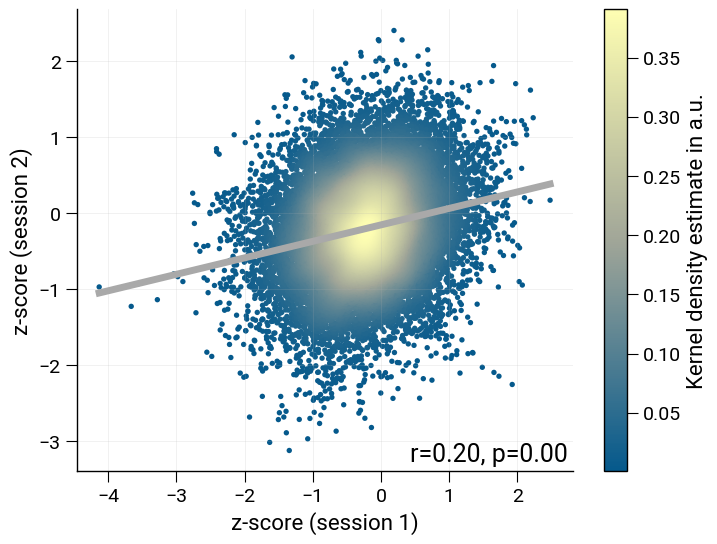

In [3]:
label, hemi = get_label(SUBJ)
data1 = np.zeros_like(hemi)
data2 = np.zeros_like(hemi)
data1[hemi == 0] = get_contrast(SUBJ, "lh", 0)[label][hemi == 0]
data1[hemi == 1] = get_contrast(SUBJ, "rh", 0)[label][hemi == 1]
data2[hemi == 0] = get_contrast(SUBJ, "lh", 1)[label][hemi == 0]
data2[hemi == 1] = get_contrast(SUBJ, "rh", 1)[label][hemi == 1]

# get subset of data for statistics
ndata = int(FRAC * len(data1))
ind = np.arange(len(data1))
random.shuffle(ind)
sample_0 = data1[ind[:ndata]]
sample_1 = data2[ind[:ndata]]

# linear fit
m, b = np.polyfit(sample_0, sample_1, 1)
x_fit = np.linspace(np.min(data1), np.max(data1), 100)
y_fit = m * x_fit + b

# statistics
r, _ = spearmanr(sample_0, sample_1)  # spearman
r_null = np.zeros(NSHUFFLE)
for i in range(NSHUFFLE):
    random.shuffle(sample_1)
    r_null[i], _ = spearmanr(sample_0, sample_1)
_, p_val = permutation_test(r, r_null)

# calculate the point density
xy = np.vstack([data1, data2])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = data1[idx], data2[idx], z[idx]

fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=z, s=15, marker="o", edgecolor="none", rasterized=True, cmap=ColMap.mpl_colormap)
ax.plot(x_fit, y_fit, color="darkgray", lw=5)
ax.set_xlabel("z-score (session 1)")
ax.set_ylabel("z-score (session 2)")
ax.text(.99, .01, f"r={r:.2f}, p={p_val:.2f}", ha='right', va='bottom', transform=ax.transAxes)
plt.colorbar(sc, label="Kernel density estimate in a.u.")
#file_out = f"/data/pt_01880/reliability_{SUBJ}_{SESS}.svg"
#fig.savefig(file_out, dpi=300, bbox_inches="tight", transparent=True, format="svg")